# Barents Sea example

In this notebook we want to attempt a few things in the Barents Sea as an example:

- TS and volume distributions over 2014
- TS and volume distributinos over the 5-year period
- specific properties and their variation with T and S (T will be on x axis, heat flux sum on y-axis as an example, or summed advective flux on y-axis)
- label water masses or think about what can be seen in these TS diagrams

### Import packages, libraries, functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

### Read grid and masks

In [2]:
# define basin we want
iB = 6   # see mskBasin if you want for later; maybe we should write this to file

In [3]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

In [4]:
bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

In [5]:
# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

In [6]:
# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

In [7]:
# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

(50,) (50, 1350, 270)


In [8]:
mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

hf1 (1350, 270)
shape of tracer fld: (1, 900, 540)
(1, 1350, 270)
compact shape (1, 1350, 270)


In [9]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

In [10]:
# write the wet mask and also set to nan
wetmask = mygrid['hFacC']
print(wetmask.shape)
wetmask_tracer = get_aste_tracer(wetmask,nfx,nfy)
print("hey",wetmask_tracer.shape)
wetmask_tracer[:,450:,:270] = np.nan
wetmask = aste_tracer2compact(wetmask_tracer,nfx,nfy)
print(wetmask.shape)

(50, 1350, 270)
hey (50, 900, 540)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
(50, 1350, 270)


In [11]:
dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsBasin = {'title' : 'CanadaB: 0, ChukchiS: 1, MakarovB: 2, AmundsenB: 3, NansenB: 4, BeringS: 5, BarentsS: 6, GINs: 7, CAA: 8, SPG: 9, LabSea: 10, NPac: 11, NAtlantic: 12, AtlS30: 13',
              'standard_name' : 'Basins labeled',
             'units' : 'degree_c'}

attrsWet= {'title' : 'model wet points in compact form',
         'standard_name' : '1= wet, 0=dry',
         'units' : 'boolean'}

# add mskBasin and wetmask to the xarray for the dataset
mskBasin_3D = xr.DataArray(data = mskBasin*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsBasin)

mskBasin_2D = xr.DataArray(data = mskBasin*wetmask[0,:,:],
                    dims = dims[1:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = attrsBasin)

wetmask_xr = xr.DataArray(data = wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsWet)


ds = xr.Dataset()
ds['mskBasin_3D'] = mskBasin_3D
ds['mskBasin_2D'] = mskBasin_2D
ds['wetmask'] = wetmask_xr

In [12]:
# get the number of points in the basin and we can use this as a mask for later
mymsk = mskBasin.copy()
mymsk[mymsk != iB] = np.nan
npoints = len(np.where(mymsk == iB)[0])   # set number of points in the basin to be used later
print(npoints)

10650


### Get the timesteps we want

In [13]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.arange(12,13,1)
times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

### Calculate tendencies

In [14]:
# ocean and ice
AB_gT=0
AB_gS=0
debug = False

In [15]:
# ffac = 1e-6
ffac = 1

In [16]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx)) * wetmask[0,:,:]

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol

print(vol.shape)

volume allocation shape (2, 50, 1350, 270)
(2, 50, 1350, 270)


In [17]:
# for heat tendency (J/s) - time not yet included here
# read the fldList
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# for each time step read the files
h_tend = np.zeros((len(tsstr),nz, ny, nx))
print("heat tendency allocation shape",h_tend.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    THETADR,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    THETADR = np.reshape(THETADR,(nz,ny,nx)) * wetmask[:,:,:]

    tmpheat = myparms['rcp']*(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)  # J/(m^3*degC) * degC*m * m^2 = J
    
    h_tend[t,:,:,:] = tmpheat

print(h_tend.shape)

heat tendency allocation shape (2, 50, 1350, 270)
(2, 50, 1350, 270)


In [18]:
# for salt tendency (kg PSU/s) or (g/s) - time not yet included here
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# for each time step read the files
sal_tend = np.zeros((len(tsstr),nz, ny, nx))
print("heat tendency allocation shape",h_tend.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    SALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    SALTDR = np.reshape(SALTDR,(nz,ny,nx)) * wetmask[:,:,:]

    tmpsalt = myparms['rhoconst'] * (SALTDR - AB_gS) * mk3D_mod(RAC,SALTDR)   # kg/m^3 * PSU*m * m^2 = kg*(g/kg) = g
    
    sal_tend[t,:,:,:] = tmpsalt

print(sal_tend.shape)

heat tendency allocation shape (2, 50, 1350, 270)
(2, 50, 1350, 270)


### Now we can read and bin thetadr and saltdr

In [19]:
dirrun_small = "/scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/"

binsTH = rdmds(dirrun_small + "layers2TH", -1)
binsTH_edges = binsTH[:,:,0].flatten()
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

binsSLT = rdmds(dirrun_small + "layers1SLT", -1)
binsSLT_edges = binsSLT[:,:,0].flatten()
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

In [20]:
# read in the initial model T-S fields
# create an array to store the values at all time steps
fileTS = np.zeros((len(tsstr),2,nz,ny,nx))
print(fileTS.shape)

# read each of the files from the list
for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = int(t1)

    # read the file
    thisfileTS = rdmds(dirIn + "budg3d_snap_set2",read)    # dr values, z, y, x
    thisfldListTS = parsemeta(dirIn + "budg3d_snap_set2." + tsstr[t] + ".meta")["fldList"]
    
    thisfileTS = thisfileTS.reshape(2,nz, ny, nx)

    fileTS[t,:,:,:,:] = thisfileTS

(2, 2, 50, 1350, 270)


In [21]:
# we should unweight these before we add them to the dataset
DRF3d = mk3D_mod(mygrid["DRF"],np.zeros((nz, ny, nx)))
temp = fileTS[:,0,:,:,:] / DRF3d
salt = fileTS[:,1,:,:,:] / DRF3d

In [22]:
# mask with wetmask
temp *= wetmask[np.newaxis,:,:,:]
salt *= wetmask[np.newaxis,:,:,:]

# set where not equal to basin to nan
bool_msk = mskBasin!= iB
vol[:,:,bool_msk] = np.nan
temp[:,:,bool_msk] = np.nan
salt[:,:,bool_msk] = np.nan   # shape time, dz, dy, dx

# also multiply heat by bool_msk
h_tend[:,:,bool_msk] = np.nan
sal_tend[:,:,bool_msk] = np.nan

### Now write to dataset

In [23]:
dims = ("iteration","z","compact_x","compact_y")
coords = {"iteration" : datetimes,
          "z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsT = {'title' : 'wighted T data from budg3d_snap_set2 example from official ASTE',
         'standard_name' : 'temperature',
         'units' : 'degree_c'}

attrsS = {'title' : 'weighted S data from budg3d_snap_set2 example from official ASTE',
         'standard_name' : 'salinity',
         'units' : 'ppt'}

attrsVol = {'title' : 'volume calculated from budg2d_snap_set1',
         'standard_name' : 'volume (m^3)',
         'units' : 'ppt'}

In [24]:
temp = xr.DataArray(data = temp,
                    dims = dims,
                    coords = coords,
                    attrs = attrsT)

salt = xr.DataArray(data = salt,
                    dims = dims,
                    coords = coords,
                    attrs = attrsS)

volume = xr.DataArray(data = vol,
                    dims = dims,
                    coords = coords,
                    attrs = attrsVol)

saltdr = xr.DataArray(data = sal_tend,
                    dims = dims,
                    coords = coords,
                    attrs = attrsVol)

thetadr = xr.DataArray(data = h_tend,
                    dims = dims,
                    coords = coords,
                    attrs = attrsVol)

In [25]:
ds = xr.Dataset({'theta': temp, 'salinity': salt, 'volume':volume, 'saltdr':saltdr,'thetadr':thetadr})
del salt,temp,vol,saltdr,thetadr

### Do the binning in TS - add to array

In [26]:
# create this as an xarray and add it to the dataset
# now the bins should go up to 112
binned_theta = bin_array(ds.theta.values,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
# print(np.nanmin(binned_theta),np.nanmin(ds.theta.values),binsTH_edges[int(np.nanmin(binned_theta))])
binned_salinity = bin_array(ds.salinity.values,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan
# print(np.nanmin(binned_salinity),np.nanmin(ds.salinity.values),binsSLT_edges[int(np.nanmin(binned_salinity))])

binned_temp = xr.DataArray(data = binned_theta*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsT)

binned_salt = xr.DataArray(data = binned_salinity*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsS)

In [27]:
ds["theta_binned"] = binned_temp
ds["salinity_binned"] = binned_salt

del binned_temp,binned_salt

In [28]:
del binned_theta, binned_salinity

In [29]:
binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

### Let's create meshes for the mass, heat and salt tendencies

In [48]:
volmesh = create_mesh(ds,nS,nT,npoints,"volume",mskBasin,iB,dT,dS)
print(1)
saltmesh = create_mesh(ds,nS,nT,npoints,"saltdr",mskBasin,iB,dT,dS)
print(2)
tempmesh = create_mesh(ds,nS,nT,npoints,"thetadr",mskBasin,iB,dT,dS)

1
2


In [49]:
# add the mesh to the dataset
attrsmesh = {'title' : 'mesh for basin with volumes at each T and S bin',
         'standard_name' : 'volume mesh',
         'units' : 'm^3/deg C/PSU'}
attrsthetadr = {'title' : 'mesh for basin with heat at each T and S bin',
         'standard_name' : 'volume mesh',
         'units' : 'J/deg C/PSU'}
attrssaltdr = {'title' : 'mesh for basin with salt at each T and S bin',
         'standard_name' : 'volume mesh',
         'units' : 'g/deg C/PSU'}
dims = ("iteration","i_Tbins","i_Sbins","points")
coords = {"iteration" : datetimes,
          "i_Tbins" : np.arange(0,nT,1),
          "i_Sbins" : np.arange(0,nS,1),
          "points" : np.arange(0,npoints,1)}

In [50]:
# syntax
volmesh = xr.DataArray(data = volmesh,
                    dims = dims,
                    coords = coords,
                    attrs = attrsmesh)

thetamesh = xr.DataArray(data = tempmesh,
                    dims = dims,
                    coords = coords,
                    attrs = attrsmesh)

saltmesh = xr.DataArray(data = saltmesh,
                    dims = dims,
                    coords = coords,
                    attrs = attrsmesh)
ds["vol_mesh"] = volmesh
ds["theta_mesh"] = thetamesh
ds["salt_mesh"] = saltmesh

In [51]:
del volmesh,thetamesh,saltmesh

### Plotting for snap volumes

In [60]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('RdBu_r',21).copy()
cmap.set_under(color='white')

In [61]:
Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)

In [62]:
# make density contours lines function
# add the polygons and the points
smin = 25 - (0.01 * 25)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38. + (0.01 * 38.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2.5 + (0.1 * -2.5)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 10 + (0.1 * 10)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 30
ydim = 30
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2.5,10,ydim)
si = np.linspace(25,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

# convert to practical/potential if needed
# long = 73.5089
# lat = -66.8245
# ti = gsw.pt_from_CT(si1,ti1)
# si = gsw.SP_from_SA(si1,0,long,lat)

tmin, tmax, smin, smax sizes=, -2.75 11.0 24.75 38.38


### Calculate tendency for time steps

In [63]:
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/"

In [64]:
ds

<xarray.Dataset>
Dimensions:          (iteration: 2, z: 50, compact_x: 1350, compact_y: 270,
                      i_Tbins: 112, i_Sbins: 112, points: 10650)
Coordinates:
  * iteration        (iteration) datetime64[ns] 2014-12-01 2015-01-01
  * z                (z) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * compact_x        (compact_x) int64 0 1 2 3 4 5 ... 1345 1346 1347 1348 1349
  * compact_y        (compact_y) int64 0 1 2 3 4 5 6 ... 264 265 266 267 268 269
  * i_Tbins          (i_Tbins) int64 0 1 2 3 4 5 6 ... 106 107 108 109 110 111
  * i_Sbins          (i_Sbins) int64 0 1 2 3 4 5 6 ... 106 107 108 109 110 111
  * points           (points) int64 0 1 2 3 4 ... 10645 10646 10647 10648 10649
Data variables:
    theta            (iteration, z, compact_x, compact_y) float64 nan ... nan
    salinity         (iteration, z, compact_x, compact_y) float64 nan ... nan
    volume           (iteration, z, compact_x, compact_y) float64 nan ... nan
    saltdr           (iteration, z, compact_x, compact_y) float64 nan ... nan
    thetadr          (iteration, z, compact_x, compact_y) float64 nan ... nan
    theta_binned     (iteration, z, compact_x, compact_y) float64 nan ... nan
    salinity_binned  (iteration, z, compact_x, compact_y) float64 nan ... nan
    vol_mesh         (iteration, i_Tbins, i_Sbins, points) float64 0.0 ... 0.0
    theta_mesh       (iteration, i_Tbins, i_Sbins, points) float64 0.0 ... 0.0
    salt_mesh        (iteration, i_Tbins, i_Sbins, points) float64 0.0 ... 0.0

2678400


(-2.5, 10.0)

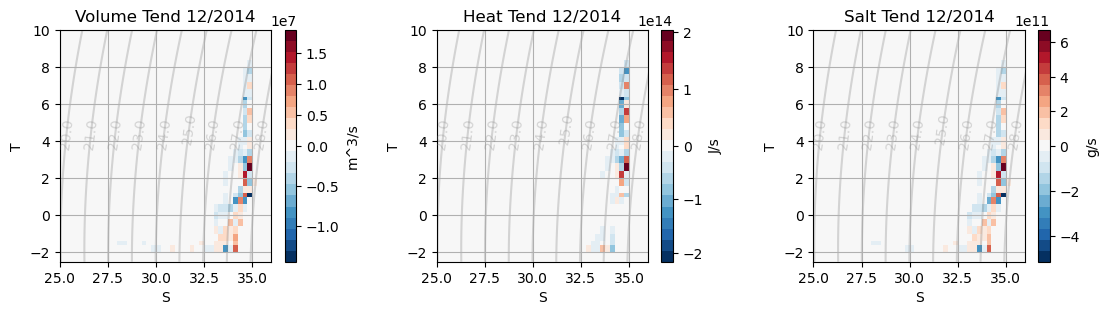

In [68]:
# get the difference in time of q to plot in x/y space
num_plots = 3
rows = 1
cols = 3
fig,axes = plt.subplots(rows,cols,figsize=(12,4))
fig.tight_layout(pad=5.0)

axes = axes.flatten()
dt = (ds.iteration[-1].values - ds.iteration[-2].values) * 1e-9   # seconds
print(int(dt))
#########################
# plot mass tendency
ax = axes[0]
tendvol = ds.vol_mesh.values[-1,:,:,:] - ds.vol_mesh.values[-2,:,:,:] # m^3/psu/degC/month
tendvol/=int(dt)                                                      # m^3/s/psu/degC
tendvol = np.nansum(tendvol,axis=2)
norm = TwoSlopeNorm(vcenter=0)
cb = ax.pcolormesh(Sbin,Tbin,tendvol, norm=norm, cmap=cmap)

# add isopycnals
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.3,levels=np.arange(20,30,1))
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
    
# labels
fig.colorbar(cb,label="m^3/s")
ax.set_title("Volume Tend 12/2014")
ax.set_xlabel("S")
ax.set_ylabel("T")
ax.grid()
ax.set_xlim(25,36)
ax.set_ylim(-2.5,10)

#########################
# plot heat tendency
ax = axes[1]
tendheat = ds.theta_mesh.values[-1,:,:,:] - ds.theta_mesh.values[-2,:,:,:] # J/psu/degC/month
tendheat/=int(dt)                                                          # J/s/psu/degC
tendheat = np.nansum(tendheat,axis=2)
norm = TwoSlopeNorm(vcenter=0)
cb = ax.pcolormesh(Sbin,Tbin,tendheat, norm=norm, cmap=cmap)

# add isopycnals
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.3,levels=np.arange(20,30,1))
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
    
# labels
fig.colorbar(cb,label="J/s")
ax.set_title("Heat Tend 12/2014")
ax.set_xlabel("S")
ax.set_ylabel("T")
ax.grid()
ax.set_xlim(25,36)
ax.set_ylim(-2.5,10)

#############################
# plot salt tendency
ax = axes[2]
tendsalt = ds.salt_mesh.values[-1,:,:,:] - ds.salt_mesh.values[-2,:,:,:]   # g/psu/degC/month
tendsalt/=int(dt)                                                          # g/s/psu/degC
tendsalt = np.nansum(tendsalt,axis=2)
norm = TwoSlopeNorm(vcenter=0)
cb = ax.pcolormesh(Sbin,Tbin,tendsalt, norm=norm, cmap=cmap)

# add isopycnals
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.3,levels=np.arange(20,30,1))
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
    
# labels
fig.colorbar(cb,label="g/s")
ax.set_title("Salt Tend 12/2014")
ax.set_xlabel("S")
ax.set_ylabel("T")
ax.grid()
ax.set_xlim(25,36)
ax.set_ylim(-2.5,10)
# plt.savefig(path + "Barents_tend_2014_v4.png",dpi = 300)

### Add the transformation vectors

In [78]:
# specifically we need Jx/LSto_TS and Jy/LTto_TS
# LSto_TS: Layer thickness tendency due to all SALT terms.  (m/s)
# LTto_TS: Layer thickness tendency due to all THETA terms. (m/s)

# I think each volume has a vector determined by tendheat and tendsalt
testlen = tendvol[91,14]   # this is the length of the vector which is determined by volume change
test_jy = tendheat[91,14]  # how much testlen will change due to heat
test_jx = tendsalt[91,14]  # how much testlen will change due to salt

# we can plot a volume distribution of december

(112, 112)

In [84]:
myvolume = np.nansum(ds.vol_mesh.values[0,:,:,:],axis=2)
plt

4282809972947287.0

In [99]:
np.count_nonzero(tendsalt)

1304

In [100]:
np.count_nonzero(tendheat)

1304

In [103]:
np.count_nonzero(tendvol)
Tbin.shape

(113, 113)

(-2.5, 10.0)

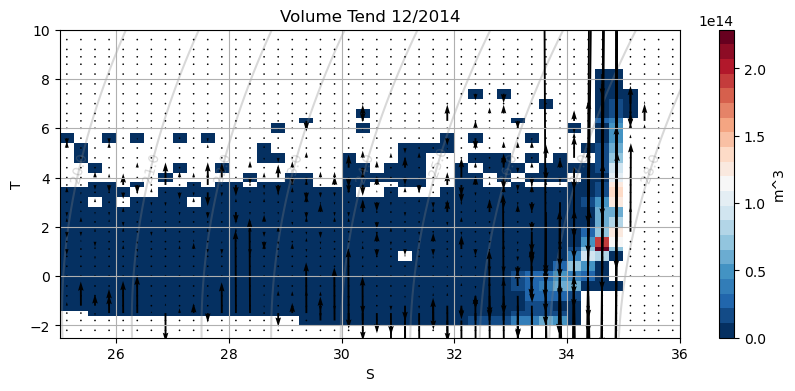

In [111]:
fig = plt.figure()
ax = plt.subplot(111)
cmap = plt.get_cmap('RdBu_r',21).copy()
cmap.set_under(color='white')
cb = ax.pcolormesh(Sbin,Tbin,myvolume,cmap=cmap,vmin=0.001)

# add isopycnals
cs = ax.contour(si, ti, dens2, colors="grey", zorder=1,alpha=0.3,levels=np.arange(20,30,1))
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.1f")
Tbin2,Sbin2 = np.meshgrid(binsTH_centers,binsSLT_centers)
hh = plt.quiver(Sbin2, Tbin2, tendsalt, tendheat, scale=None,width=0.003)
    
# labels
fig.colorbar(cb,label="m^3")
ax.set_title("Volume Tend 12/2014")
ax.set_xlabel("S")
ax.set_ylabel("T")
ax.grid()
ax.set_xlim(25,36)
ax.set_ylim(-2.5,10)

### Try to plot with diagnostics

### Plot distribution with OceQnet/try vertical convergence

In [40]:
file_name = 'budg2d_zflux_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(["oceQsw"])             # W/m^2, net surface heat flux into the ocean (+=down), >0 increases theta
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
q = np.zeros((len(tsstr), ny, nx))
print("volume allocation shape",q.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    #t2 = tsstr[t+1]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    oceQsw,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    # select by existing basin in mskBasin
    oceQsw = np.reshape(oceQsw,(ny,nx)) * wetmask[0,:,:] * mymsk

    # we want to isolate oceQsw by multiplying by RAC (the surface)
    tmpq = RAC * oceQsw      # m^2 * W/m^2 = W

    # add this time step to the mesh
    q[t,:,:] = tmpq     # W

print(q.shape)

volume allocation shape (2, 1350, 270)
(2, 1350, 270)


In [41]:
dims = ("iteration","compact_x","compact_y")
coords = {"iteration" : datetimes,
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsq = {'title' : 'oceQnet',
         'standard_name' : 'net surface heat flux into the ocean (+=down), >0 increases theta',
         'units' : 'W/m^2'}

oceqnet = xr.DataArray(data = q,
                    dims = dims,
                    coords = coords,
                    attrs = attrsq)

ds["oceQnet"] = oceqnet
del oceqnet,q

In [42]:
# add q to the dataset so we can check the function
attr = "oceQnet"
testmesh = create_mesh(ds,nS,nT,npoints,attr,mskBasin,iB,dT,dS)